In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as time
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score, confusion_matrix

In [2]:
# Loading data

f = open("data.npy", "rb")
data = np.load(f, allow_pickle=True)

# Checking dimension of data
data.shape

(1500, 5)

In [3]:
# First converting to pandas dataframe
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4
0,9f894201-9d0d-4f75-853b-595c0c1bd661,"[[-0.001002429, 0.047839083, -0.0046581626, 0....","[[0.31094703, 0.20213455, -0.16519593, -0.0530...",sleep,33.144312
1,d2b4d879-0345-4df1-a978-eb7f9e8b89f1,"[[-0.013190677, 0.08283211, 0.006474074, 0.001...","[[-0.07832227, -0.07557866, -0.05214904, -0.32...",oven,98.512848
2,aaf0c209-f3a7-4c91-9a09-bc1e30400c4c,"[[-0.010499587, 0.047467805, -0.019303396, -0....","[[0.31455985, -0.024428558, 0.33139282, 0.2197...",chair,15.449425
3,5ae313c7-9934-456c-9685-36ef20b712fd,"[[-0.023966337, 0.024375185, -0.0009961016, -0...","[[0.113364324, -0.23683439, 0.34781978, -0.427...",igloo,43.358541
4,b58bbb2c-461f-4805-856e-cba323f97e8c,"[[-0.018555297, 0.050565578, -0.008821793, 0.0...","[[0.22332864, -0.28626534, -0.037617087, -0.17...",fish,14.454734


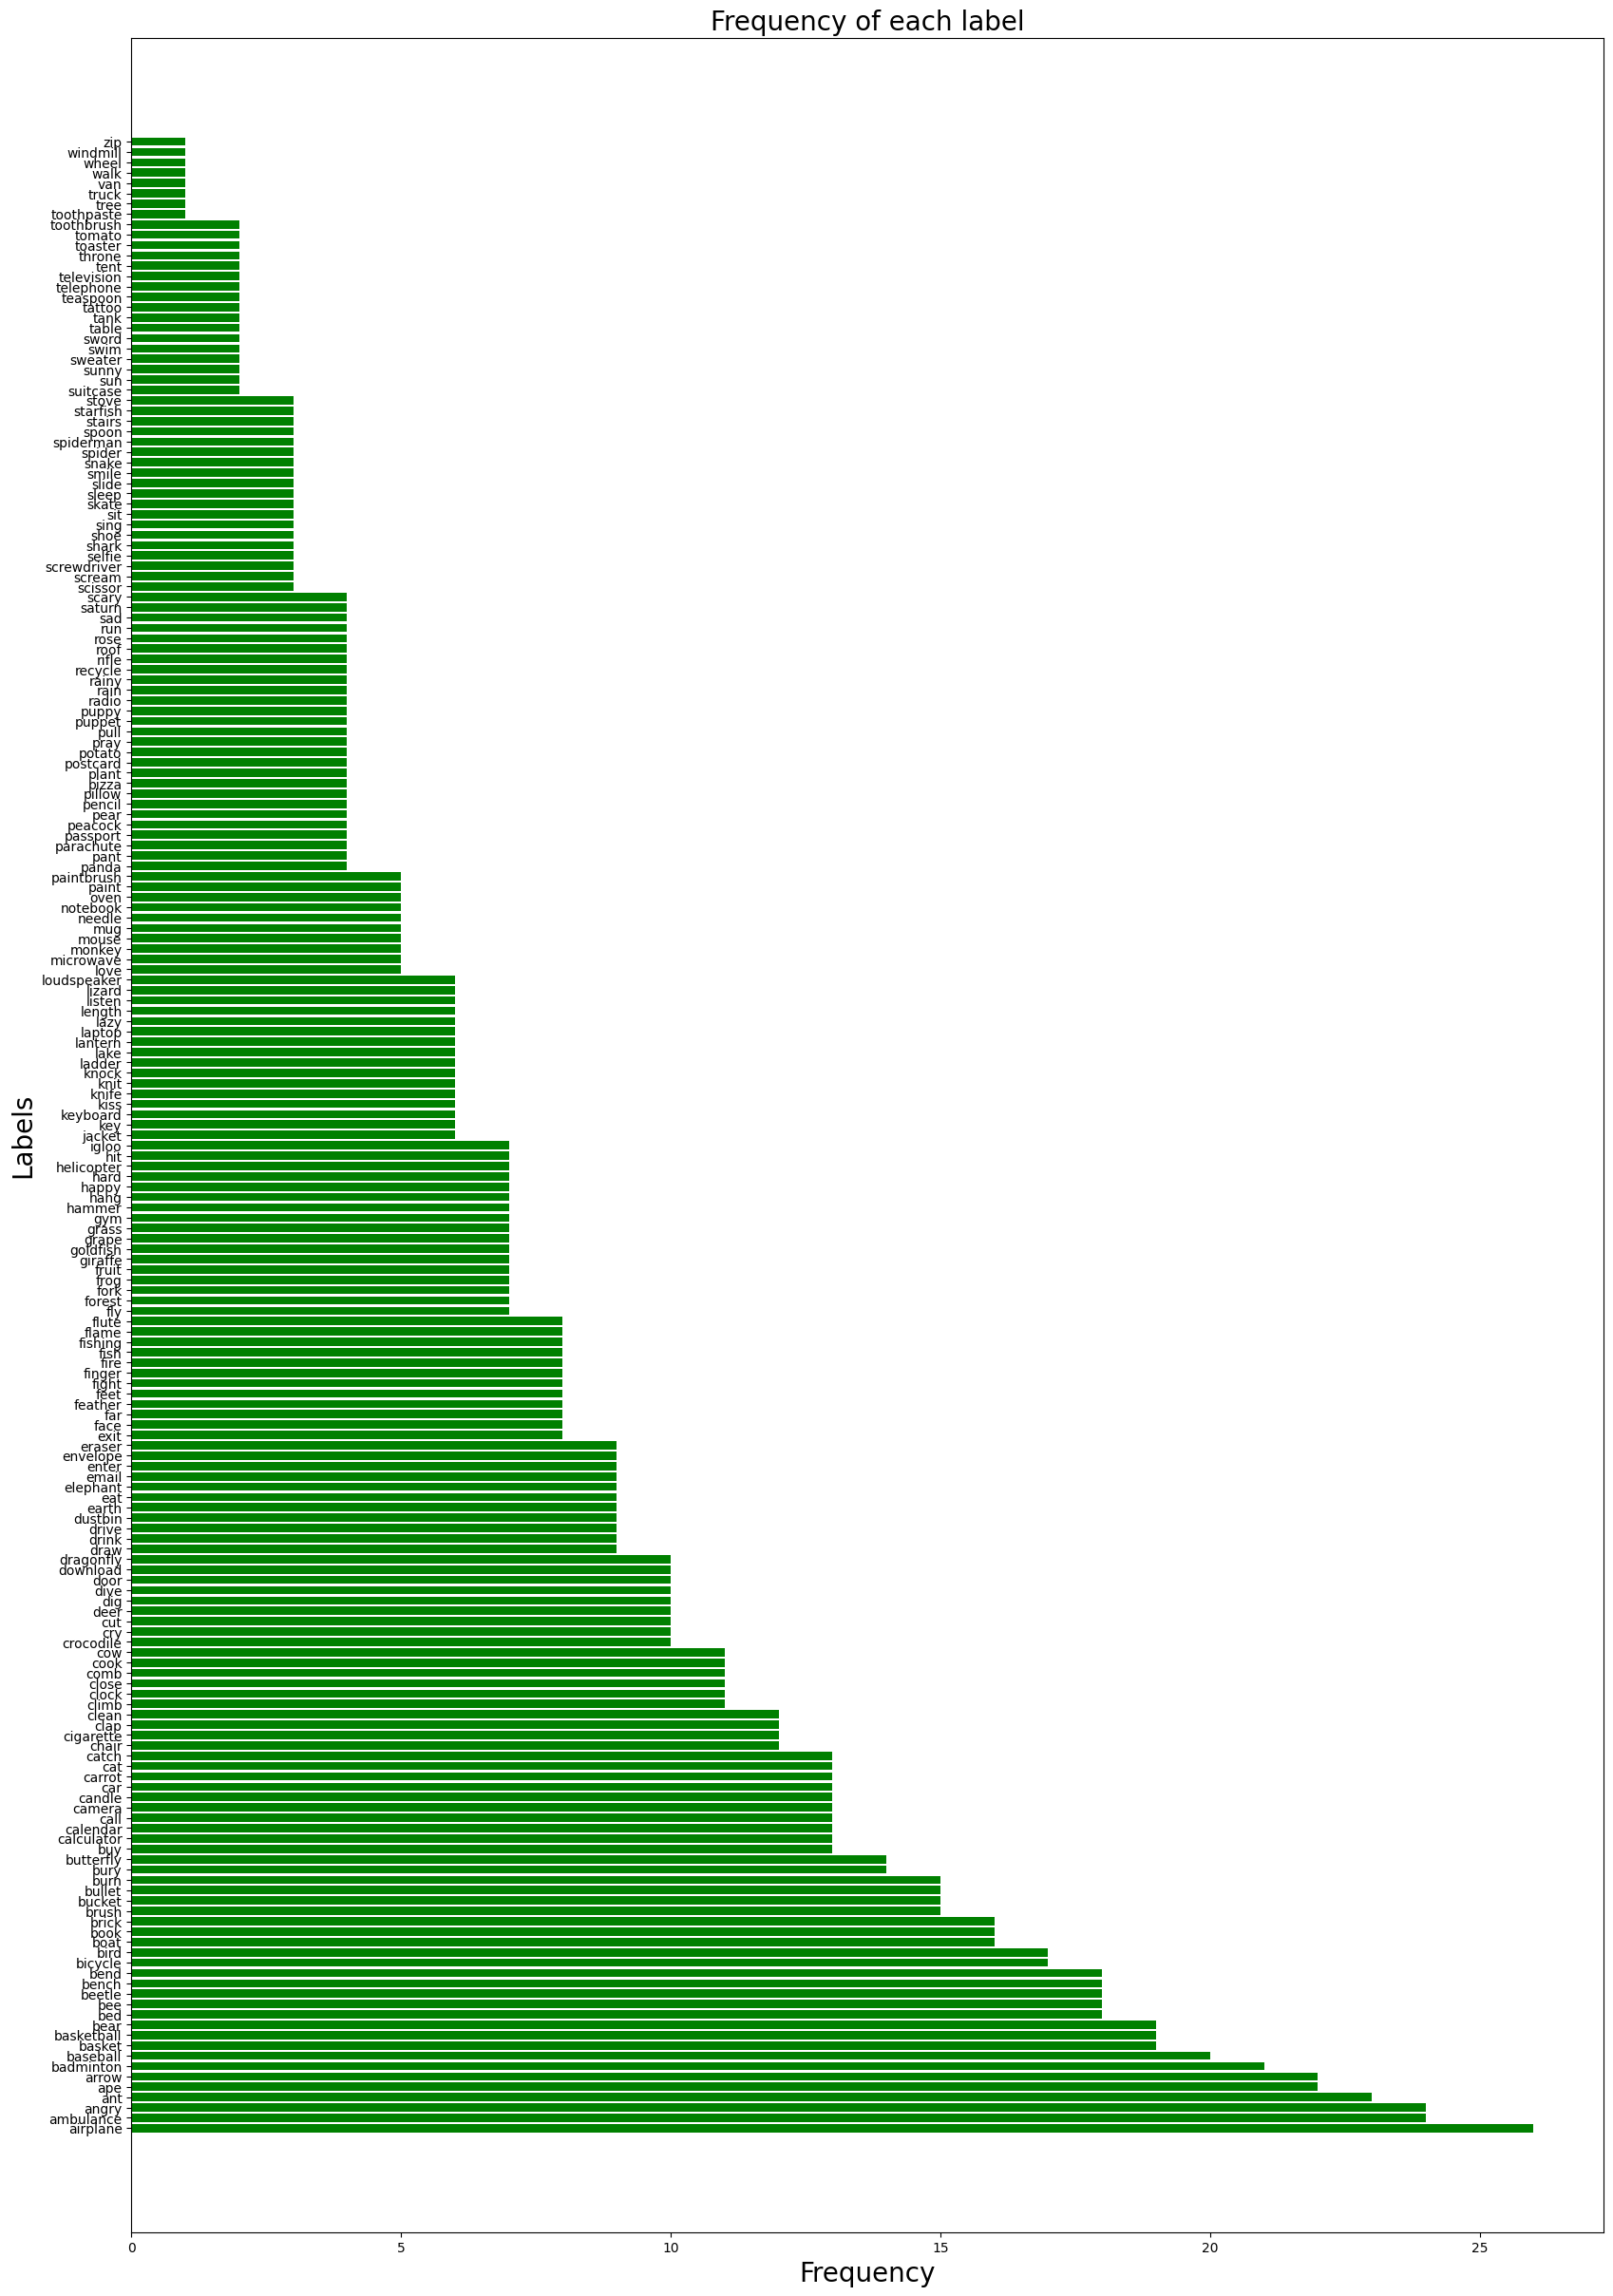

In [4]:
# Extracting unique labels from data[:,3]
labels = np.unique(data[:,3])
# Plotting a horizontal bar graph for the frequency of each label with proper figure size and font size
plt.figure(figsize=(20,30))
plt.barh(labels,df[3].value_counts(),color='green')
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Labels',fontsize=20)
plt.title('Frequency of each label',fontsize=20)
plt.show()

# Visualizing data

In [5]:
# The embeddings
X_resnet = df.iloc[:,1]
X_vit = df.iloc[:,2]
df = pd.DataFrame({'ResNet': X_resnet, 'ViT': X_vit})
df.head()

,ResNet,ViT
0,"[[-0.001002429, 0.047839083, -0.0046581626, 0....","[[0.31094703, 0.20213455, -0.16519593, -0.0530..."
1,"[[-0.013190677, 0.08283211, 0.006474074, 0.001...","[[-0.07832227, -0.07557866, -0.05214904, -0.32..."
2,"[[-0.010499587, 0.047467805, -0.019303396, -0....","[[0.31455985, -0.024428558, 0.33139282, 0.2197..."
3,"[[-0.023966337, 0.024375185, -0.0009961016, -0...","[[0.113364324, -0.23683439, 0.34781978, -0.427..."
4,"[[-0.018555297, 0.050565578, -0.008821793, 0.0...","[[0.22332864, -0.28626534, -0.037617087, -0.17..."


In [6]:
# Defining different distance metrics

def euclidean_distance(x1, x2):
    # to match shape
    x1 = x1.flatten()
    x2 = x2.flatten()
    dist = np.sqrt(np.sum((x2 - x1)**2))
    return dist

def manhattan_distance(x1, x2):
    x1 = x1.flatten()
    x2 = x2.flatten()
    dist = np.sum(np.abs(x2 - x1))
    return dist

def cosine_distance(x1, x2):
    x1 = x1.flatten()
    x2 = x2.flatten()
    dist = np.dot(x1, x2)
    dist /= (np.sqrt(np.sum(x1**2)) * np.sqrt(np.sum(x2**2)))
    dist = 1 - dist
    return dist



In [7]:
# KNN Model Class

class KNNModel():
    def __init__(self, k, distance_metric, encoder_type):
        self.k = k
        self.distance_metric = distance_metric
        self.encoder_type = encoder_type
        self.X_train = None
        self.y_train = None
        self.y_test = None
        self.X_test = None
        self.y_pred = None

    def pred(self):
        y_pred = []
        
        for x in self.X_test:
            if(self.distance_metric == 'euclidean'):
                distance_arr = [euclidean_distance(X_train, x) for X_train in self.X_train]
            elif(self.distance_metric == 'manhattan'):
                distance_arr = [manhattan_distance(X_train, x) for X_train in self.X_train]
            elif(self.distance_metric == 'cosine'):
                distance_arr = [cosine_distance(X_train, x) for X_train in self.X_train]       
            sorted_dist = np.argsort(distance_arr)
            k_nearest_indices = sorted_dist[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_nearest_indices]
            count = {}
            for label in k_nearest_labels:
                count[label] = count.get(label, 0) + 1
            mode = max(count, key=count.get)
            y_pred.append(mode)
        self.y_pred = y_pred
        return y_pred   

    def acc(self):
        accuracy = accuracy_score(self.y_test,self.y_pred)
        # print(f"The accuracy is {accuracy}")
        return accuracy
        

    def precision(self):
        precision = precision_score(self.y_test,self.y_pred, average='micro')
        # print(f"The precision is {precision}")
        return precision

    def recall(self):
        recall = recall_score(self.y_test,self.y_pred, average='micro')
        # print(f"The recall is {recall}")
        return recall

    def f1(self):
        f1 = f1_score(self.y_test,self.y_pred, average='micro')
        # print(f"The f1 score is {f1}") 
        return f1
  
         
    

In [8]:
from sklearn.model_selection import train_test_split
def tt_split_knn(model, data):
    if(model.encoder_type == 'resnet'):
        model.X_train, model.X_test, model.y_train, model.y_test = train_test_split(data[:,1],
                                                    data[:,3],
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # Make random split reproducible
    if(model.encoder_type == 'vit'):
        model.X_train, model.X_test, model.y_train, model.y_test = train_test_split(data[:,2],
                                                    data[:,3],
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # Make random split reproducible                                                

In [9]:
def ModelRunner(model):
    start_time = time.time()
    model.pred()
    end_time = time.time()
    print(f"For model with k = {model.k}, distance metric = {model.distance_metric} and encoder type = {model.encoder_type}:")
    model.acc()
    model.precision()
    model.recall()
    model.f1()
    time_taken = end_time - start_time
    print(f"Time taken for execution is {time_taken} seconds")
    return time_taken

In [10]:
# Running all combinations of k, distance metric and encoder type
answer_list = []

for k in range(1, 31):
    for distance_metric in ['euclidean', 'manhattan', 'cosine']:
        for encoder_type in ['resnet', 'vit']:
            model = KNNModel(k, distance_metric, encoder_type)
            tt_split_knn(model, data)
            time_taken = ModelRunner(model)
            a = model.acc()
            b = model.precision()
            c = model.recall()
            d = model.f1()
            print(f"Accuracy is {a}, Precision is {b}, Recall is {c}, F1 score is {d}")
            answer_list.append([k, distance_metric, encoder_type, a, b, c, d, time_taken])

For model with k = 1, distance metric = euclidean and encoder type = resnet:
Time taken for execution is 3.7972793579101562 seconds
Accuracy is 0.18666666666666668, Precision is 0.18666666666666668, Recall is 0.18666666666666668, F1 score is 0.18666666666666668
For model with k = 1, distance metric = euclidean and encoder type = vit:
Time taken for execution is 3.9888949394226074 seconds
Accuracy is 0.27, Precision is 0.27, Recall is 0.27, F1 score is 0.27
For model with k = 1, distance metric = manhattan and encoder type = resnet:
Time taken for execution is 4.02676248550415 seconds
Accuracy is 0.18666666666666668, Precision is 0.18666666666666668, Recall is 0.18666666666666668, F1 score is 0.18666666666666668
For model with k = 1, distance metric = manhattan and encoder type = vit:
Time taken for execution is 3.4256186485290527 seconds
Accuracy is 0.27666666666666667, Precision is 0.27666666666666667, Recall is 0.27666666666666667, F1 score is 0.27666666666666667
For model with k = 1

In [11]:
best_acc = sorted(answer_list, key=lambda x: x[3], reverse=True)
best_time = sorted(answer_list, key=lambda x: x[7])
print(f"Best accuracy is for k = {best_acc[0][0]}, distance metric = {best_acc[0][1]} and encoder type = {best_acc[0][2]}, accuracy is {best_acc[0][3]}")
print(f"Second best accuracy is for k = {best_acc[1][0]}, distance metric = {best_acc[1][1]} and encoder type = {best_acc[1][2]}, accuracy is {best_acc[1][3]}")
print(f"Third best accuracy is for k = {best_acc[2][0]}, distance metric = {best_acc[2][1]} and encoder type = {best_acc[2][2]}, accuracy is {best_acc[2][3]}")
print(f"Fourth best accuracy is for k = {best_acc[3][0]}, distance metric = {best_acc[3][1]} and encoder type = {best_acc[3][2]}, accuracy is {best_acc[3][3]}")
print(f"Fifth best accuracy is for k = {best_acc[4][0]}, distance metric = {best_acc[4][1]} and encoder type = {best_acc[4][2]}, accuracy is {best_acc[4][3]}")
print(f"Sixth best accuracy is for k = {best_acc[5][0]}, distance metric = {best_acc[5][1]} and encoder type = {best_acc[5][2]}, accuracy is {best_acc[5][3]}")
print(f"Seventh best accuracy is for k = {best_acc[6][0]}, distance metric = {best_acc[6][1]} and encoder type = {best_acc[6][2]}, accuracy is {best_acc[6][3]}")
print(f"Eighth best accuracy is for k = {best_acc[7][0]}, distance metric = {best_acc[7][1]} and encoder type = {best_acc[7][2]}, accuracy is {best_acc[7][3]}")
print(f"Ninth best accuracy is for k = {best_acc[8][0]}, distance metric = {best_acc[8][1]} and encoder type = {best_acc[8][2]}, accuracy is {best_acc[8][3]}")
print(f"Tenth best accuracy is for k = {best_acc[9][0]}, distance metric = {best_acc[9][1]} and encoder type = {best_acc[9][2]}, accuracy is {best_acc[9][3]}")
print(f"Elevent best accuracy is for k = {best_acc[10][0]}, distance metric = {best_acc[10][1]} and encoder type = {best_acc[10][2]}, accuracy is {best_acc[10][3]}")
print(f"Twelveth best accuracy is for k = {best_acc[11][0]}, distance metric = {best_acc[11][1]} and encoder type = {best_acc[11][2]}, accuracy is {best_acc[11][3]}")
print(f"Thirteenth best accuracy is for k = {best_acc[12][0]}, distance metric = {best_acc[12][1]} and encoder type = {best_acc[12][2]}, accuracy is {best_acc[12][3]}")
print(f"Fourteenth best accuracy is for k = {best_acc[13][0]}, distance metric = {best_acc[13][1]} and encoder type = {best_acc[13][2]}, accuracy is {best_acc[13][3]}")
print(f"Fifteenth best accuracy is for k = {best_acc[14][0]}, distance metric = {best_acc[14][1]} and encoder type = {best_acc[14][2]}, accuracy is {best_acc[14][3]}")
print(f"Sixteenth best accuracy is for k = {best_acc[15][0]}, distance metric = {best_acc[15][1]} and encoder type = {best_acc[15][2]}, accuracy is {best_acc[15][3]}")
print(f"Seventeenth best accuracy is for k = {best_acc[16][0]}, distance metric = {best_acc[16][1]} and encoder type = {best_acc[16][2]}, accuracy is {best_acc[16][3]}")
print(f"Eighteenth best accuracy is for k = {best_acc[17][0]}, distance metric = {best_acc[17][1]} and encoder type = {best_acc[17][2]}, accuracy is {best_acc[17][3]}")
print(f"Nineteenth best accuracy is for k = {best_acc[18][0]}, distance metric = {best_acc[18][1]} and encoder type = {best_acc[18][2]}, accuracy is {best_acc[18][3]}")
print(f"Twentieth best accuracy is for k = {best_acc[19][0]}, distance metric = {best_acc[19][1]} and encoder type = {best_acc[19][2]}, accuracy is {best_acc[19][3]}")
print(f"Most optimized time is for k = {best_time[0][0]}, distance metric = {best_time[0][1]} and encoder type = {best_time[0][2]}, time taken is {best_time[0][7]}")

Best accuracy is for k = 12, distance metric = manhattan and encoder type = vit, accuracy is 0.2966666666666667
Second best accuracy is for k = 13, distance metric = manhattan and encoder type = vit, accuracy is 0.2966666666666667
Third best accuracy is for k = 4, distance metric = manhattan and encoder type = vit, accuracy is 0.29
Fourth best accuracy is for k = 14, distance metric = manhattan and encoder type = vit, accuracy is 0.2866666666666667
Fifth best accuracy is for k = 3, distance metric = manhattan and encoder type = vit, accuracy is 0.28
Sixth best accuracy is for k = 10, distance metric = manhattan and encoder type = vit, accuracy is 0.28
Seventh best accuracy is for k = 11, distance metric = manhattan and encoder type = vit, accuracy is 0.28
Eighth best accuracy is for k = 1, distance metric = manhattan and encoder type = vit, accuracy is 0.27666666666666667
Ninth best accuracy is for k = 2, distance metric = manhattan and encoder type = vit, accuracy is 0.276666666666666

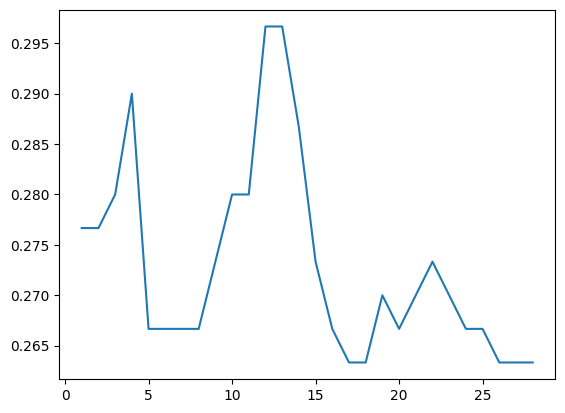

In [12]:
# For manhattan distance as distance metric and vit as encoder type, plotting the graph of accuracy vs k, taking k from 1 to 30 and accuracy values from answer_list
acc_val = []
k = []
for i in range(3,170,6):
    acc_val.append(answer_list[i][3])
    k.append(answer_list[i][0])

plt.plot(k, acc_val)

In [13]:
# Default sklearn knn model
from sklearn.neighbors import KNeighborsClassifier

# Taking vit encoding
X_train, X_test, y_train, y_test = train_test_split(data[:,2], data[:,3], test_size = 0.2, random_state = 42)
X_train = X_train.flatten()
y_train = y_train.flatten()

# Default model takes data in format of a list
X_train_list = []
for i in range(len(X_train)):
    X_train_list.append(X_train[i].flatten())
    # print(X_train[i].shape)
y_train_list = []
for i in range(len(y_train)):
    y_train_list.append(y_train[i])

X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i].flatten())
    # print(X_train[i].shape)

k = 12
sklearn_knn = KNeighborsClassifier(k)
sklearn_knn.fit(X_train_list, y_train_list)

# print(X_train_list)

# print(X_train.shape)

KNeighborsClassifier(n_neighbors=12)

In [14]:
starttime_defknn = time.time()
y_pred = sklearn_knn.predict(X_test_list)
endtime_defknn = time.time()
sklearnknn_time = endtime_defknn - starttime_defknn
print(f'Accuracy of default sklearn KNN for k = {k}, distance metric = manhattan, encoding = vit is', accuracy_score(y_test, y_pred))

Accuracy of default sklearn KNN for k = 12, distance metric = manhattan, encoding = vit is 0.22666666666666666


In [15]:
best_acc_k = best_acc[0][0]
best_acc_dist = best_acc[0][1]
best_acc_encoding = best_acc[0][2]

model_best_acc = KNNModel(12, 'manhattan', 'vit')
tt_split_knn(model_best_acc, data)
start_time = time.time()
model_best_acc.pred()
end_time = time.time()
best_acc_time = end_time - start_time

best_time_time = best_time[0][7]

<BarContainer object of 3 artists>

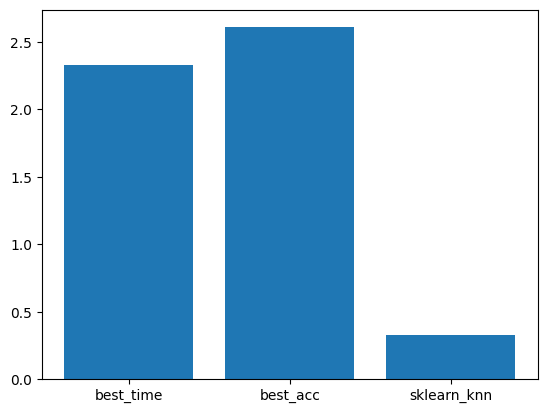

In [16]:
# Plotting times of best_time, best_acc and sklearn_knn models as bar plots
plt.bar(['best_time', 'best_acc', 'sklearn_knn'], [best_time_time, best_acc_time, sklearnknn_time])

# Decision Tree


In [17]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as time
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score, confusion_matrix

In [18]:
# Visualizing data as pandas dataframe
df = pd.read_csv("advertisement.csv")
df

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home
...,...,...,...,...,...,...,...,...,...,...,...
995,61,Male,34246.773063,Master,True,3,Solisfurt,HR,103.357441,bed,food furniture
996,56,Female,45494.225591,Bachelor,False,0,Dawsonmouth,Engineer,85.159023,biscuits,home clothing food
997,64,Female,68740.442006,PhD,True,0,Lake Garyport,Salesman,101.434650,bat,sports clothing
998,18,Female,44348.446680,Bachelor,True,0,Ericfurt,Retired,97.649988,perfume,beauty


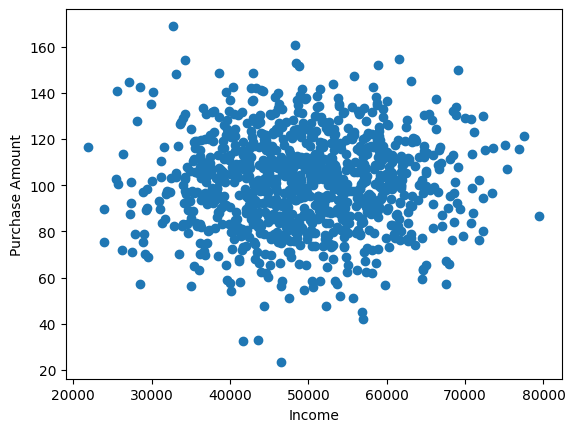

In [19]:
# Plotting income and purchase amount
plt.scatter(df['income'], df['purchase_amount'])
plt.xlabel('Income')
plt.ylabel('Purchase Amount')
plt.show()

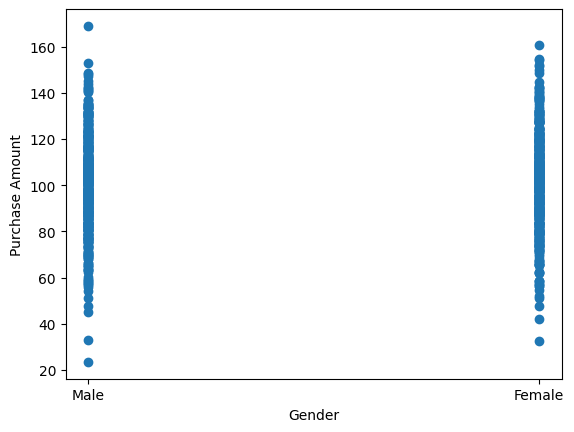

In [20]:
# Plotting income and purchase amount
plt.scatter(df['gender'], df['purchase_amount'])
plt.xlabel('Gender')
plt.ylabel('Purchase Amount')
plt.show()

Overall interpretation of the data is that the dat is spread well uniformly

In [21]:
# Converting to np array
data = df.to_numpy()

In [22]:
# Performing label encoding on the categorical data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data[:, 1] = labelencoder.fit_transform(data[:, 1])
data[:, 3] = labelencoder.fit_transform(data[:, 3])
data[:, 4] = labelencoder.fit_transform(data[:, 4])
data[:, 5] = labelencoder.fit_transform(data[:, 5])
data[:, 6] = labelencoder.fit_transform(data[:, 6])
data[:, 7] = labelencoder.fit_transform(data[:, 7])
data[:, 9] = labelencoder.fit_transform(data[:, 9])


In [23]:
# Converting data to dataframe to visualize
df = pd.DataFrame(data)
df

,0,1,2,3,4,5,6,7,8,9,10
0,45,1,61271.953359,2,0,3,366,2,87.697118,16,electronics clothing sports
1,24,0,53229.101074,1,0,1,98,1,115.135586,13,furniture beauty
2,45,0,30066.046684,0,1,3,403,3,101.694559,3,clothing electronics food sports
3,19,1,48950.246384,3,0,0,959,6,97.964887,14,food
4,29,0,44792.627094,2,0,0,521,1,86.847281,4,home
...,...,...,...,...,...,...,...,...,...,...,...
995,61,1,34246.773063,2,1,3,763,4,103.357441,2,food furniture
996,56,0,45494.225591,0,0,0,111,3,85.159023,3,home clothing food
997,64,0,68740.442006,3,1,0,341,8,101.43465,1,sports clothing
998,18,0,44348.44668,0,1,0,195,7,97.649988,19,beauty


In [24]:
# Removing labels to pre-process separately, remaining data will be our X
y = data[:, 10]
data = np.delete(data, 10, 1)

In [25]:
# Separating all unique elements which are space separated in elements of y
for i in range(len(y)):
    y[i] = y[i].split(" ")

# Extracting unique labels
unique_labels = []
for i in range(len(y)):
    for j in range(len(y[i])):
        if(y[i][j] not in unique_labels):
            unique_labels.append(y[i][j])   

unique_labels 

['electronics',
 'clothing',
 'sports',
 'furniture',
 'beauty',
 'food',
 'home',
 'books']

In [26]:
# Making power set for the unique labels
# Generated by GPT start
def power_set(labels):
    n = len(labels)
    power_set = [[]]

    for label in labels:
        new_subsets = []
        for subset in power_set:
            new_subsets.append(subset + [label])
        power_set.extend(new_subsets)

    return power_set

# Generated by GPT end
 
labels_power_set = power_set(unique_labels)

In [27]:
# Sorting every column of y
for i in range(len(y)):
    y[i].sort()

# Sorting labels_power_set
for i in range(len(labels_power_set)): 
    labels_power_set[i].sort()


In [28]:
# Mapping indexes to power set
index_list = []

for i in range(len(y)):
    index_list.append(labels_power_set.index(y[i]))

# Total 254 labels
print(max(index_list))


254


In [39]:
# Label encoding y for the MultiOutput formulation
y_encoded = labelencoder.fit_transform([str(i) for i in y])

201

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
# Building a wrapper class for DecisionTree 
class DecisionTreeModel():
    def __init__(self, max_depth, max_features, criterion):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.X_train = None
        self.y_train = None
        self.y_test = None
        self.X_test = None
        self.y_pred = None

    def pred(self):
        classifier = DecisionTreeClassifier(max_depth = self.max_depth, max_features = self.max_features, criterion = self.criterion)
        classifier.fit(self.X_train, self.y_train)
        self.y_pred = classifier.predict(self.X_test)
        return self.y_pred   

    def acc(self):
        accuracy = accuracy_score(self.y_test,self.y_pred)
        # print(f"The accuracy is {accuracy}")
        return accuracy        

    def precision(self):
        precision = precision_score(self.y_test,self.y_pred, average='micro')
        # print(f"The precision is {precision}")
        return precision

    def recall(self):
        recall = recall_score(self.y_test,self.y_pred, average='micro')
        # print(f"The recall is {recall}")
        return recall

    def f1(self):
        f1 = f1_score(self.y_test,self.y_pred, average='micro')
        # print(f"The f1 score is {f1}") 
        return f1
    
    def f1_macro(self):
        f1_mac = f1_score(self.y_test,self.y_pred, average='macro')
        return f1_mac
    
    def confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        return cm



In [32]:
def ModelRunnerDT(model):
    start_time = time.time()
    model.pred()
    end_time = time.time()
    print(f"For model with max_depth = {model.max_depth}, max_features = {model.max_features} and criterion = {model.criterion}:")
    # model.acc()
    # model.precision()
    # model.recall()
    # model.f1()
    time_taken = end_time - start_time
    print(f"Time taken for execution is {time_taken} seconds")
    return time_taken

In [33]:
from sklearn.model_selection import train_test_split

def tt_split_tree_powerset(model, data):  
    model.X_train, model.X_test, model.y_train, model.y_test = train_test_split(data,
                                                    index_list,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # Make random split reproducible

def tt_split_tree_multilabel(model, data):  
    model.X_train, model.X_test, model.y_train, model.y_test = train_test_split(data,
                                                    y_encoded,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # Make random split reproducible
   

In [34]:
# For Power Set:
answer_list = []

for max_depth in [3,5,10,20,30]:
    for max_features in [3,5,7,9,11]:
        for criterion in ['gini', 'entropy']:
            model = DecisionTreeModel(max_depth, max_features, criterion)
            tt_split_tree_powerset(model, data)
            time_taken = ModelRunnerDT(model)
            a = model.acc()
            b = model.precision()
            c = model.recall()
            d = model.f1()
            e = model.f1_macro()
            f = model.confusion_matrix()
            print(f"Accuracy is {a}, Precision is {b}, Recall is {c}, Micro F1 score is {d}, Macro F1 score is {e}, Confusion Matrix is {f}")
            answer_list.append([max_depth, max_features, criterion, a, b, c, d, e, f, time_taken])

For model with max_depth = 3, max_features = 3 and criterion = gini:
Time taken for execution is 0.006000995635986328 seconds
Accuracy is 0.05, Precision is 0.05, Recall is 0.05, Micro F1 score is 0.05000000000000001, Macro F1 score is 0.00851124321530111, Confusion Matrix is [[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
For model with max_depth = 3, max_features = 3 and criterion = entropy:
Time taken for execution is 0.013974905014038086 seconds
Accuracy is 0.04, Precision is 0.04, Recall is 0.04, Micro F1 score is 0.04, Macro F1 score is 0.003498239595558364, Confusion Matrix is [[1 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
For model with max_depth = 3, max_features = 5 and criterion = gini:
Time taken for execution is 0.0060045719146728516 seconds
Accuracy is 0.045, Precision is 0.045, Recall is 0.045, Micro F1 score is 0.045, Macro F1 

In [35]:
best_F1_micro = sorted(answer_list, key=lambda x: x[6], reverse=True)
print("For Powerset formulation:")
print(f"Best micro F1 score is for max_depth = {best_F1_micro[0][0]}, max_features = {best_F1_micro[0][1]} and criterion = {best_F1_micro[0][2]}, micro F1 score is {best_F1_micro[0][6]}, accuracy is {best_F1_micro[0][3]}")
print(f"Second best micro F1 score is for max_depth = {best_F1_micro[1][0]}, max_features = {best_F1_micro[1][1]} and criterion = {best_F1_micro[1][2]}, micro F1 score is {best_F1_micro[1][6]}, accuracy is {best_F1_micro[0][3]}")
print(f"Third best micro F1 score is for max_depth = {best_F1_micro[2][0]}, max_features = {best_F1_micro[2][1]} and criterion = {best_F1_micro[2][2]}, micro F1 score is {best_F1_micro[2][6]}, accuracy is {best_F1_micro[0][3]}")

For Powerset formulation:
Best micro F1 score is for max_depth = 5, max_features = 11 and criterion = entropy, micro F1 score is 0.115, accuracy is 0.115
Second best micro F1 score is for max_depth = 5, max_features = 9 and criterion = entropy, micro F1 score is 0.10499999999999998, accuracy is 0.115
Third best micro F1 score is for max_depth = 3, max_features = 9 and criterion = entropy, micro F1 score is 0.095, accuracy is 0.115


### Multi Label Output

In [36]:
# For MultiOutput formulation
answer_list2 = []

for max_depth in [3,5,10,20,30]:
    for max_features in [3,5,7,9,11]:
        for criterion in ['gini', 'entropy']:
            model = DecisionTreeModel(max_depth, max_features, criterion)
            tt_split_tree_multilabel(model, data)
            time_taken = ModelRunnerDT(model)
            a = model.acc()
            b = model.precision()
            c = model.recall()
            d = model.f1()
            e = model.f1_macro()
            f = model.confusion_matrix()
            print(f"Accuracy is {a}, Precision is {b}, Recall is {c}, Micro F1 score is {d}, Macro F1 score is {e}, Confusion Matrix is {f}")
            answer_list2.append([max_depth, max_features, criterion, a, b, c, d, e, f, time_taken])

For model with max_depth = 3, max_features = 3 and criterion = gini:
Time taken for execution is 0.003997802734375 seconds


Accuracy is 0.035, Precision is 0.035, Recall is 0.035, Micro F1 score is 0.035, Macro F1 score is 0.003299191374663073, Confusion Matrix is [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]]
For model with max_depth = 3, max_features = 3 and criterion = entropy:
Time taken for execution is 0.010034322738647461 seconds
Accuracy is 0.015, Precision is 0.015, Recall is 0.015, Micro F1 score is 0.015, Macro F1 score is 0.0025802289953233346, Confusion Matrix is [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
For model with max_depth = 3, max_features = 5 and criterion = gini:
Time taken for execution is 0.0059964656829833984 seconds
Accuracy is 0.035, Precision is 0.035, Recall is 0.035, Micro F1 score is 0.035, Macro F1 score is 0.0037735849056603774, Confusion Matrix is [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1

In [37]:
best_F1_micro2 = sorted(answer_list2, key=lambda x: x[6], reverse=True)
print("For Powerset formulation:")
print(f"Best micro F1 score is for max_depth = {best_F1_micro2[0][0]}, max_features = {best_F1_micro2[0][1]} and criterion = {best_F1_micro2[0][2]}, micro F1 score is {best_F1_micro2[0][6]}, accuracy is {best_F1_micro2[0][3]}")
print(f"Second best micro F1 score is for max_depth = {best_F1_micro2[1][0]}, max_features = {best_F1_micro2[1][1]} and criterion = {best_F1_micro2[1][2]}, micro F1 score is {best_F1_micro2[1][6]}, accuracy is {best_F1_micro2[0][3]}")
print(f"Third best micro F1 score is for max_depth = {best_F1_micro2[2][0]}, max_features = {best_F1_micro2[2][1]} and criterion = {best_F1_micro2[2][2]}, micro F1 score is {best_F1_micro2[2][6]}, accuracy is {best_F1_micro2[0][3]}")

For Powerset formulation:
Best micro F1 score is for max_depth = 3, max_features = 9 and criterion = entropy, micro F1 score is 0.095, accuracy is 0.095
Second best micro F1 score is for max_depth = 3, max_features = 11 and criterion = entropy, micro F1 score is 0.095, accuracy is 0.095
Third best micro F1 score is for max_depth = 5, max_features = 7 and criterion = entropy, micro F1 score is 0.095, accuracy is 0.095
